# Content of this notebook:
- Try to improve the VGG16 
- improvement attempts:
    - data augmentation 
    - dropout
    - learing rate scheduler

In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
import pickle
from torch.optim import lr_scheduler
import PIL 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR100
RANDOM_SEED = 123
BATCH_SIZE = 64

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1. Data augmentation:
source: https://pytorch.org/vision/stable/transforms.html

Original images without transformation


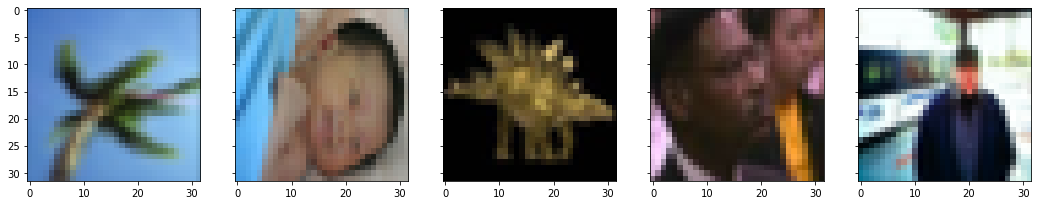

In [3]:

custom_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = CIFAR100(root="./", train=True, download=False, transform=custom_transform)
test_data = CIFAR100(root="./", train=False, download=False, transform=custom_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=1, shuffle=True)
torch.manual_seed(RANDOM_SEED)
for images, labels in train_loader:  
    images1 = images
    break
    
print('Original images without transformation')
fig, axs = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
for i in range(5):
    axs[i].imshow(np.transpose(images1[i], (1, 2, 0)))
    


Resize and RandomCrop transformation


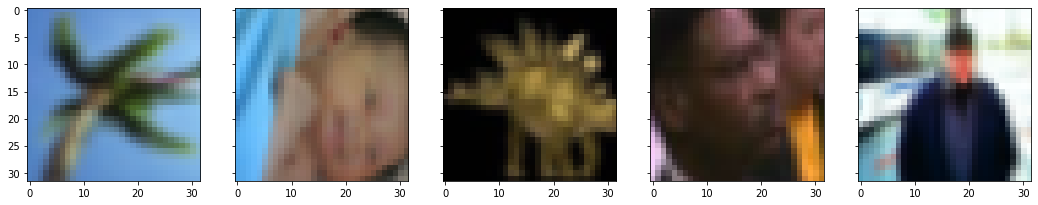

In [4]:
custom_transform = transforms.Compose([
    transforms.Resize((38, 38)),
    transforms.RandomCrop((32, 32)),
    transforms.ToTensor(),])

train_dataset = CIFAR100(root="./", train=True, download=False, transform=custom_transform)
test_data = CIFAR100(root="./", train=False, download=False, transform=custom_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=1, shuffle=True)
torch.manual_seed(RANDOM_SEED)

for images, labels in train_loader:  
    images1 = images
    break
    
print('Resize and RandomCrop transformation')
fig, axs = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
for i in range(5):
    axs[i].imshow(np.transpose(images1[i], (1, 2, 0)))

Random rotation between -120°-120° and RandomCrop transformation


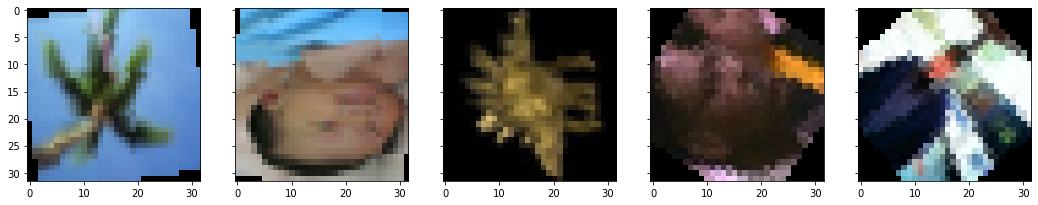

In [5]:
custom_transform = transforms.Compose([
    transforms.RandomRotation(degrees=120),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

train_dataset = CIFAR100(root="./", train=True, download=False, transform=custom_transform)
test_data = CIFAR100(root="./", train=False, download=False, transform=custom_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=1, shuffle=True)
torch.manual_seed(RANDOM_SEED)

for images, labels in train_loader:  
    images1 = images
    break
    
print('Random rotation between -120°-120° and RandomCrop transformation')
fig, axs = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
for i in range(5):
    axs[i].imshow(np.transpose(images1[i], (1, 2, 0)))

All transformations together


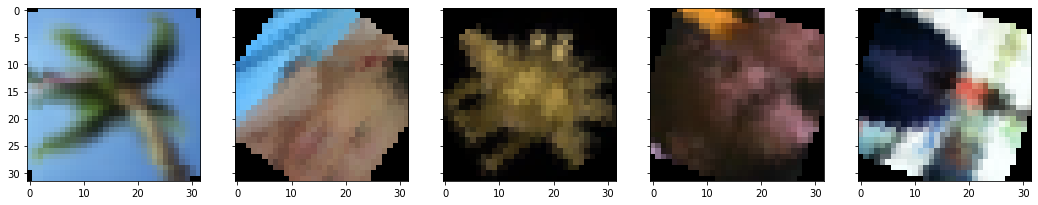

In [6]:
custom_transform = transforms.Compose([
    transforms.Resize((38, 38)),
    transforms.RandomCrop((32, 32)),
    transforms.RandomRotation(degrees=120),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()])

train_dataset = CIFAR100(root="./", train=True, download=False, transform=custom_transform)
test_data = CIFAR100(root="./", train=False, download=False, transform=custom_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=1, shuffle=True)
torch.manual_seed(RANDOM_SEED)

for images, labels in train_loader:  
    images1 = images
    break
    
print('All transformations together')
fig, axs = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
for i in range(5):
    axs[i].imshow(np.transpose(images1[i], (1, 2, 0)))

### Load data, transform data and split data set

In [7]:
from torch.utils.data import random_split
batch_size = 64

custom_transform = transforms.Compose([
    
    transforms.Resize((38, 38)),
    transforms.RandomCrop((32, 32)),
    transforms.RandomRotation(degrees=120),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
    ])

train_dataset = CIFAR100(root="./", train=True, download=False, transform=custom_transform)
test_dataset = CIFAR100(root="./", train=False, download=False, transform=custom_transform)

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(train_dataset))  
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training images train data set: ', len(train_dataset))
print('Number of validation images in train dataset: ', len(val_dataset))
print('Number of test images test data set: ', len(test_dataset))
#print('Number of different classes training set: ', len(np.unique(train_labels)))
#print('Number of different classes in validation set: ', len(np.unique(val_labels)))
#print('Number of different classes test set: ', len(np.unique(test_labels)))

Number of training images train data set:  40000
Number of validation images in train dataset:  10000
Number of test images test data set:  10000


In [8]:
# Load the label names from metadata file
with open('cifar-100-python/meta', 'rb') as f:
    meta_dict = pickle.load(f, encoding='bytes')
fine_label_names = [t.decode('utf8') for t in meta_dict[b'fine_label_names']]
print(fine_label_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [9]:
# One batch consits 64 images with 3 channels, 32x32 pixel
first_batch = next(iter(train_loader))
print('Image format (batch_size, channels, height, width):',first_batch[0].shape)

Image format (batch_size, channels, height, width): torch.Size([64, 3, 32, 32])


### VGG16 from Scratch with dropout (fully connected layer)

In [5]:
num_classes = 100

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.dropout = nn.Dropout(0.3)
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        #print('Shape: ', x.shape)
        out = self.layer1(x)
        #print('Shape: ', out.shape)
        out = self.layer2(out)
        #print('Shape: ', out.shape)
        out = self.layer3(out)
        #print('Shape: ', out.shape)
        out = self.layer4(out)
        #print('Shape: ', out.shape)
        out = self.layer5(out)
        #print('Shape: ', out.shape)
        out = self.layer6(out)
        #print('Shape: ', out.shape)
        out = self.layer7(out)
        #print('Shape: ', out.shape)
        out = self.layer8(out)
        #print('Shape: ', out.shape)
        out = self.layer9(out)
        #print('Shape: ', out.shape)
        out = self.layer10(out)
        #print('Shape: ', out.shape)
        out = self.layer11(out)
        #print('Shape: ', out.shape)
        out = self.layer12(out)
        #print('Shape: ', out.shape)
        out = self.layer13(out)
        #print('Shape: ', out.shape)
        out = out.reshape(out.size(0), -1)
        #print('Shape: ', out.shape)
        out = self.fc(out)
        out = self.dropout(out)
        #print('Shape: ', out.shape)
        out = self.fc1(out)
        out = self.dropout(out)
        #print('Shape: ', out.shape)
        out = self.fc2(out)
        #print('Last layer  Shape: ', out.shape)
        return out

In [12]:
model = VGG16(num_classes)
model = VGG16(num_classes).to(device)

## Implement dropout (fully connected layer)

In [13]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

### Trainig

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_loss_list = []
    val_loss_list = []
    epoch_list = []

    total_step = len(train_loader)

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        
        model.train()             # activate dropout
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add up the training loss for this batch
            epoch_train_loss += loss.item()

        # Compute the average training loss for this epoch
        epoch_train_loss /= len(train_loader)

        # Append the loss to the train_loss_list
        train_loss_list.append(epoch_train_loss)
        epoch_list.append(epoch+1)
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, epoch_train_loss))

        # Validation
        #model.eval()           # deactivate dropout
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs

            # Append the average validation loss to the val_loss_list
            val_loss /= len(valid_loader.dataset)
            val_loss_list.append(val_loss)
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
         
        # in each epoch call scheduler 
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print("Current learning rate: {}".format(current_lr))

    # Plot the train and validation loss
    import matplotlib.pyplot as plt
    plt.plot(epoch_list, train_loss_list, label='Train Loss')
    plt.plot(epoch_list, val_loss_list, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### Number of episodes can be increased (tests showed that overfitting does not occur as early as in previous tests)

In [15]:
num_epochs = 100
learning_rate = 0.005

model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

### How does the learning rate scheduler works:

![Beispielbild](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*wFMvRnA4NTLdt-1GTcz4Eg.png)

- source: https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863


In [16]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=35, gamma = 0.1)

Epoch [1/100], Step [625/625], Loss: 4.4365
Accuracy of the network on the 5000 validation images: 3.4 %
Current learning rate: 0.005
Epoch [2/100], Step [625/625], Loss: 4.1497
Accuracy of the network on the 5000 validation images: 6.88 %
Current learning rate: 0.005
Epoch [3/100], Step [625/625], Loss: 3.9501
Accuracy of the network on the 5000 validation images: 7.96 %
Current learning rate: 0.005
Epoch [4/100], Step [625/625], Loss: 3.8312
Accuracy of the network on the 5000 validation images: 9.4 %
Current learning rate: 0.005
Epoch [5/100], Step [625/625], Loss: 3.7529
Accuracy of the network on the 5000 validation images: 10.05 %
Current learning rate: 0.005
Epoch [6/100], Step [625/625], Loss: 3.6654
Accuracy of the network on the 5000 validation images: 11.77 %
Current learning rate: 0.005
Epoch [7/100], Step [625/625], Loss: 3.5868
Accuracy of the network on the 5000 validation images: 13.46 %
Current learning rate: 0.005
Epoch [8/100], Step [625/625], Loss: 3.4973
Accuracy o

Epoch [61/100], Step [625/625], Loss: 1.9166
Accuracy of the network on the 5000 validation images: 43.41 %
Current learning rate: 0.0005
Epoch [62/100], Step [625/625], Loss: 1.8949
Accuracy of the network on the 5000 validation images: 43.31 %
Current learning rate: 0.0005
Epoch [63/100], Step [625/625], Loss: 1.8906
Accuracy of the network on the 5000 validation images: 43.58 %
Current learning rate: 0.0005
Epoch [64/100], Step [625/625], Loss: 1.8836
Accuracy of the network on the 5000 validation images: 43.58 %
Current learning rate: 0.0005
Epoch [65/100], Step [625/625], Loss: 1.8648
Accuracy of the network on the 5000 validation images: 43.41 %
Current learning rate: 0.0005
Epoch [66/100], Step [625/625], Loss: 1.8613
Accuracy of the network on the 5000 validation images: 43.83 %
Current learning rate: 0.0005
Epoch [67/100], Step [625/625], Loss: 1.8410
Accuracy of the network on the 5000 validation images: 43.71 %
Current learning rate: 0.0005
Epoch [68/100], Step [625/625], Lo

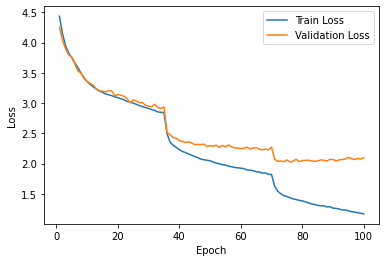

In [17]:
train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs)

### Testing the model with test set (deactivate dropout before)

In [18]:
# Testphase
model.eval()   # Dropout ist deaktiviert

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [19]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # auf cpu kopieren um in numpy array umwandeln zu könenn
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))  

target_names = fine_label_names
classification_report_result = classification_report(y_true, y_pred, target_names=target_names)
print(classification_report_result)


Accuracy of the network on the 10000 test images: 53.5 %
               precision    recall  f1-score   support

        apple       0.84      0.89      0.86       100
aquarium_fish       0.72      0.74      0.73       100
         baby       0.43      0.56      0.49       100
         bear       0.22      0.13      0.16       100
       beaver       0.34      0.39      0.36       100
          bed       0.27      0.43      0.33       100
          bee       0.67      0.69      0.68       100
       beetle       0.69      0.68      0.68       100
      bicycle       0.62      0.66      0.64       100
       bottle       0.54      0.43      0.48       100
         bowl       0.29      0.25      0.27       100
          boy       0.36      0.25      0.29       100
       bridge       0.51      0.68      0.58       100
          bus       0.40      0.42      0.41       100
    butterfly       0.60      0.52      0.56       100
        camel       0.35      0.36      0.35       100
       

In [20]:
import pandas as pd
classification_report_result_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
df_classification_report = pd.DataFrame(classification_report_result_dict).transpose()
df_classification_report[0:len(target_names)]

# Find best classified labels
sorted_df_precision = df_classification_report.sort_values('precision', ascending=False)
top5_sorted_precision = sorted_df_precision[0:5]
header_precision = "Top 5 labels precision"
sorted_df_precision = top5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
cockroach,0.865169,0.770000,0.814815,100.000000
sunflower,0.854369,0.880000,0.866995,100.000000
apple,0.839623,0.890000,0.864078,100.000000
road,0.826923,0.860000,0.843137,100.000000
orange,0.805556,0.870000,0.836538,100.000000


In [21]:
sorted_df_precision = df_classification_report.sort_values('precision')
worst5_sorted_precision = sorted_df_precision[0:5]
header_precision = "Worst 5 labels precision"
sorted_df_precision = worst5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
bear,0.224138,0.130000,0.164557,100.000000
seal,0.236111,0.170000,0.197674,100.000000
otter,0.236842,0.180000,0.204545,100.000000
lizard,0.256881,0.280000,0.267943,100.000000
girl,0.261364,0.230000,0.244681,100.000000


In [22]:
sorted_df_f1_score = df_classification_report.sort_values('f1-score')
worst5_sorted_f1_score = sorted_df_f1_score[0:5]
header_f1_score = "Worst 5 labels f1-score"
sorted_df_f1_score = worst5_sorted_f1_score.style.set_caption(header_f1_score)
sorted_df_f1_score

,precision,recall,f1-score,support
bear,0.224138,0.130000,0.164557,100.000000
seal,0.236111,0.170000,0.197674,100.000000
otter,0.236842,0.180000,0.204545,100.000000
rabbit,0.268293,0.220000,0.241758,100.000000
girl,0.261364,0.230000,0.244681,100.000000


## Summary:

##### - Accurancy on test data set 53.5% (before 49.6%)
##### - Data augmentation, dropout and learning rate scheduling reduce overfitting and make it possible to train more episodes 
##### - Sadly no big improve 
##### - Categories that can be predicted well and poorly overlap with the previous notebook despite data augmentation:
#####     - difficult to predict: bear, otter, girl
#####     - easy ato predict: apple, road